parsing equations from strings sandbox

In [1]:
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

def Bx(x):
    #border condition for x
    return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])

function_list = ['m', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)

In [19]:
power = 5

bord_w = 1000
conn_w = 100

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)


c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.2

colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),

    #HJB
    lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v /2')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),

    #variant with v from previous iteration only
    # lp('( 0 )'),

    #HJB
    lp('( (d/dx) &v )**2 /4'),
]




# def initial_state(x):
#     t, x = x
#     return (1 - np.cos(2*np.pi * x))

# def terminal_state(x):
#     t, x = x
#     return 2/3 * (1 - np.cos(2*np.pi * x))**2
# #np.sin(2*np.pi * x)**2 *2
#     # return 1 + np.cos(np.pi * x)


def initial_state(x):
    t, x = x
    return (1 - np.cos(2*np.pi * x))

def terminal_state(x):
    t, x = x
    # return 1 + np.cos(np.pi * x)
    return (1 - np.cos(2*np.pi * x))**2



# def initial_state(x):
#     t, x = x
#     return (1 - np.cos(2*np.pi * x))

# def terminal_state(x):
#     t, x = x
#     return (1 - np.cos(4*np.pi * x))


#group 1
# def initial_state(x):
#     t, x = x
#     return np.sin(x)

# def terminal_state(x):
#     t, x = x
#     return -eps*np.log(np.sin(x)) - (-eps*np.log(np.sin(sol.area_lims[1,0])))

# def f(x):
#     t, x = x
#     return eps**2 *(-np.sin(x)**(-2) + np.tan(x)**(-2)/2)

#group 2
# def initial_state(x):
#     t, x = x
#     return np.exp(x)

# def terminal_state(x):
#     t, x = x
#     return -eps*x

# def f(x):
#     t, x = x
#     return eps**2 /2

#group 2
# def initial_state(x):
#     t, x = x
#     return x * np.exp(x)

# def terminal_state(x):
#     t, x = x
#     return -eps*(x + np.log(x))

# def f(x):
#     t, x = x
#     return eps**2 /2 * (1 + 2/x -1/x**2)

d1 = 10

border_left_operators = [
    lp('bord_w * Bx(x) * (d/dx) v'),
    lp('bord_w * BtT(x) * ( v + d1* m * 2*(- &m + terminal_state(x)))'),
    
    lp('bord_w * Bx(x) * (d/dx) m'),
    lp('bord_w * BtI(x) * m'),
]
border_right_operators = [
    lp('bord_w * Bx(x)* 0'),
    lp('bord_w * BtT(x) * d1*(terminal_state(x)**2 - &m **2)'),
    lp('bord_w * Bx(x)* 0'),
    lp('bord_w * BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

#TODO fix for lp to use func_num!
k1 = 10

for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: k1 * (u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1])
        )*conn_w,
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: k1 *(u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1])
        )*conn_w,
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

colloc_w, border_w,connect_w = 1, 100, 100

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['t', 'x'],
        'weights': [colloc_w, border_w,connect_w] 
        }

In [27]:
sol.cell_division(0)

In [28]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs, func_num=0, derivatives = [0,0]):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), derivatives, func_num)
    return res_array

exact_sol = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        exact_sol[i,j] = initial_state(np.array([t,x]))

new_eval=ev(sol)
division_counter = 0
print('Iter \t| ', 'Coefs diff','\t| ', 'm diff', '\t| ', 'm abs error', '\t| ','Cost func')
tab_prec = "%.5E"
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    # err = np.max(np.abs(new_eval - exact_sol))
    # cost_func = np.sum((ev(sol,ts,xs,1, [0,1]))**2)
    residual = np.max(np.abs(A @ np.ravel(sol.cells_coefs) - b))
    print(j,'\t| ', tab_prec % np.max(np.abs(prev_coefs - sol.cells_coefs)),'\t| ',tab_prec % change, '\t| ', tab_prec % residual)#, tab_prec % err, '\t| ', tab_prec % cost_func)
    if change < 1e-4:
        division_counter +=1
        sol.cell_division(division_counter % 2)
        print('---cells dividied---')
    # if err < 1e-8:
    #     break

Iter 	|  Coefs diff 	|  m diff 	|  m abs error 	|  Cost func
0 	|  3.87769E-01 	|  5.71855E-01 	|  3.24545E+00
1 	|  2.56522E-01 	|  2.63735E-01 	|  1.61621E+00
2 	|  9.36256E-02 	|  1.61866E-01 	|  8.12326E-01
3 	|  1.11520E-01 	|  1.38702E-01 	|  7.78592E-01
4 	|  1.57839E-01 	|  2.48648E-01 	|  7.84165E-01
5 	|  1.03212E-01 	|  1.50964E-01 	|  8.64772E-01
6 	|  1.61426E-01 	|  2.31525E-01 	|  7.74780E-01
7 	|  1.12255E-01 	|  1.51996E-01 	|  7.70040E-01
8 	|  1.25067E+00 	|  1.60164E+00 	|  6.46380E-01
9 	|  6.57300E-01 	|  7.95000E-01 	|  3.05176E+00
10 	|  2.86334E-01 	|  3.81900E-01 	|  2.25021E+00
11 	|  1.46750E-01 	|  2.01655E-01 	|  1.13355E+00
12 	|  9.94227E-02 	|  1.35090E-01 	|  7.83256E-01
13 	|  1.94963E-01 	|  2.38336E-01 	|  8.15951E-01
14 	|  1.25812E+00 	|  6.78465E-01 	|  9.25181E-01


KeyboardInterrupt: 

In [ ]:
print('Iter \t| ', 'Coefs diff','\t| ', 'Sol diff', '\t| ', 'm abs error', '\t| ','Cost func')
tab_prec = "%.5E"
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.solve(solver='np', verbose = True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    err = np.max(np.abs(new_eval - exact_sol))
    cost_func = np.sum((ev(sol,ts,xs,1, [0,1]))**2)

    print(j,'\t| ', tab_prec % np.max(np.abs(prev_coefs - sol.cells_coefs)),'\t| ',tab_prec % change, '\t| ', tab_prec % err, '\t| ', tab_prec % cost_func)
    if change < 1e-9:
        division_counter +=1
        sol.cell_division(division_counter % 2)
        print('---cells dividied---')
    if err < 1e-8:
        break

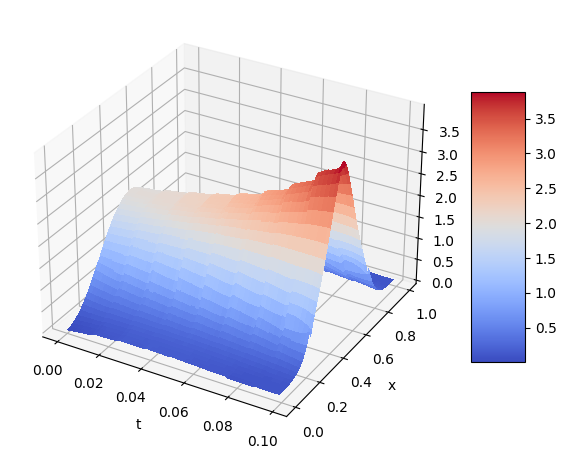

In [29]:
sol.plot2d(func_num=0)

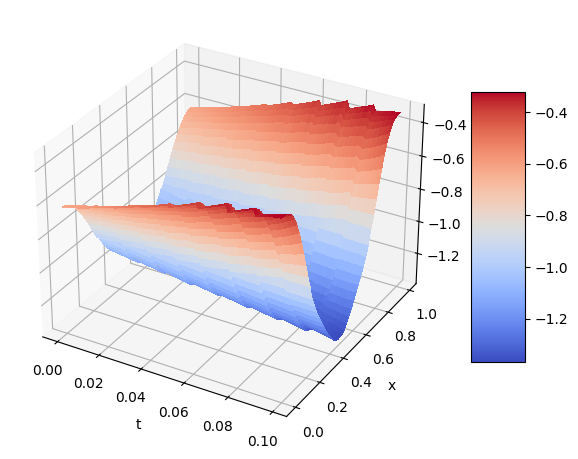

In [30]:
sol.plot2d(func_num=1)

In [ ]:
sol.cell_division(1)

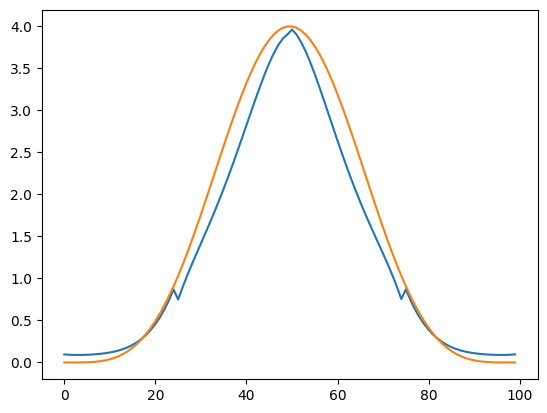

In [31]:
import matplotlib.pyplot as plt
a = np.zeros(100)
b = np.zeros(100)

i=0
for xi in np.linspace(0,1-1e-5,100):
    # b[i] = initial_state([0, xi])
    b[i] = terminal_state([0, xi])
    a[i] = sol.eval(np.array([0.099, xi]), [0,0])
    i+=1
plt.plot(a)
plt.plot(b)

AttributeError: AxesImage.set() got an unexpected keyword argument 'dpi'

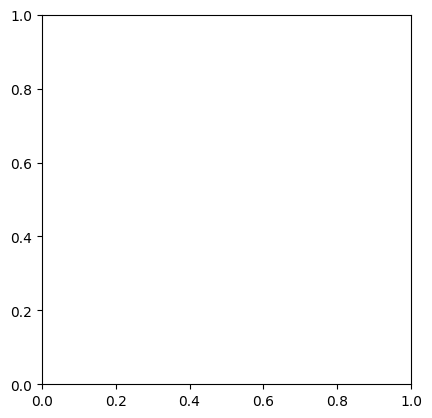

In [34]:
plt.imshow(A)

In [33]:
np.sum(a)/100

1.3217813524961426

## Dynamical example

In [ ]:
power = 5

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[1,1.1], [0.2*np.pi,0.8*np.pi]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.5
c = eps
colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
    #HJB
    lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
    #HJB
    lp('f(x) + ( (d/dx) &v )**2 /2'),
]

def initial_state(x):
    t, x = x
    return np.exp(-t*x) * t/(1-np.exp(-t))

def terminal_state(x):
    t, x = x
    return x**2 / 2/t + x*( (t+1)*(np.exp(t)-1)/(t**2) - eps*t)

def f(x):
    t, x = x
    return ( np.exp(-2*t)/(2*t**6) * (-2*np.exp(t)*((t-2)*(t+1)*(c*t**3+t+2)+
                                                  (t-2)*(t+1)*t**3*x*np.log(t) + 
                                                  (t**3-4*t-6)*t**2*x)-
                                    np.exp(2*t)*(t**3*np.log(t))*(2*c*t**3*(x+1)+t**3*x**2*np.log(t)+2*(t+2)*x)+
                                    (c*t**3+t+2)**2+t**5*(-x**2)+4*(t+3)*t**2*x-(t-2)**2*(t+1)**2) )
# scopes may be wrong!

border_left_operators = [
    lp('Bx(x) * v'),
    lp('BtT(x) * ( m - v )'),
    lp('Bx(x) * m'),
    lp('BtI(x) * m'),
]
border_right_operators = [
    lp('Bx(x)* terminal_state(x)'),
    lp('BtT(x) * (initial_state(x) - terminal_state(x))'),
    lp('Bx(x)*initial_state(x)'),
    lp('BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [ ]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs, func_num=0, derivatives = [0,0]):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), derivatives, func_num)
    return res_array

exact_sol = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        exact_sol[i,j] = initial_state(np.array([t,x]))

new_eval=ev(sol)
division_counter = 0
print('Iter \t| ', 'Coefs diff','\t| ', 'Sol diff', '\t| ', 'Sol error', '\t| ','Cost func')
tab_prec = "%.5E"

for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    err = np.max(np.abs(new_eval - exact_sol))
    cost_func = np.sum((ev(sol,ts,xs,1, [0,1]))**2)/n/n

    print(j,'\t| ', tab_prec % np.max(np.abs(prev_coefs - sol.cells_coefs)),'\t| ',tab_prec % change, '\t| ', tab_prec % err, '\t| ', tab_prec % cost_func)
    if change < 1e-9:
        division_counter +=1
        sol.cell_division(division_counter % 2)
        print('---cells dividied---')
    if err < 1e-8:
        break

sol.plot2d()

Iter 	|  Coefs diff 	|  Sol diff 	|  Sol error 	|  Cost func
0 	|  8.53800E+00 	|  8.45715E-01 	|  6.31401E-02 	|  1.97290E+01
1 	|  7.85845E-01 	|  8.99894E-02 	|  7.57959E-02 	|  2.01432E+01
2 	|  1.41101E-01 	|  4.63232E-02 	|  8.07290E-02 	|  1.99051E+01
3 	|  2.97149E-02 	|  9.19123E-03 	|  7.37757E-02 	|  1.99270E+01
4 	|  1.09076E-02 	|  4.42400E-03 	|  7.60454E-02 	|  1.99168E+01
5 	|  3.68864E-03 	|  1.11716E-03 	|  7.53254E-02 	|  1.99211E+01
6 	|  1.22899E-03 	|  3.98423E-04 	|  7.55759E-02 	|  1.99197E+01
7 	|  4.22786E-04 	|  1.31798E-04 	|  7.54914E-02 	|  1.99202E+01
8 	|  1.43449E-04 	|  4.56872E-05 	|  7.55205E-02 	|  1.99200E+01
9 	|  4.90562E-05 	|  1.54487E-05 	|  7.55106E-02 	|  1.99201E+01
10 	|  1.67089E-05 	|  5.29358E-06 	|  7.55140E-02 	|  1.99201E+01
11 	|  5.70301E-06 	|  1.80114E-06 	|  7.55129E-02 	|  1.99201E+01
12 	|  1.94440E-06 	|  6.15095E-07 	|  7.55133E-02 	|  1.99201E+01
13 	|  6.63299E-07 	|  2.09650E-07 	|  7.55131E-02 	|  1.99201E+01
14 	|  2.26

KeyboardInterrupt: 

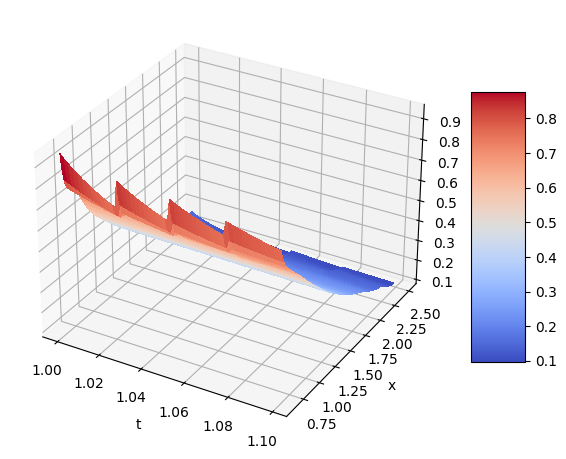

In [ ]:
sol.plot2d(func_num=0)

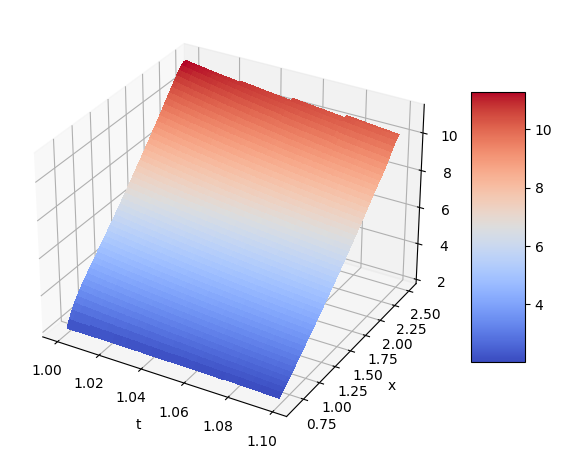

In [ ]:
sol.plot2d(func_num=1)

In [ ]:
power = 3

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.14

c0=1
c1=0.1
c2=1
c3=0.8

colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
    #HJB
    lp('(d/dt) v + eps * (d/dx)^2 v - (d/dx) v * (d/dx) &v /2 + m * c0*x[1]/(c1+c2* &m )**2')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
    #HJB
    lp('(- (d/dx) &v )**2 /4 - p(x[1])*(1-c3*x[0]) - c0*x[1]/(c1+c2* &m )'),
]

xc = (sol.area_lims[1,0]+sol.area_lims[1,1])/2
epsC = 0.01
a=1/np.sqrt(epsC**(1.5)*np.pi) * np.exp(-(xc)**2/epsC)

def initial_state(x):
    t, x = x
    return 1/np.sqrt(epsC*np.pi) * np.exp(-(x-xc)**2/epsC) + a*(x-xc)**2

def p(t):
    return 1

b_w = 10

border_left_operators = [
    lp('Bx(x) * (d/dx) v *b_w'),
    lp('BtT(x) * v *b_w'),
    lp('Bx(x) * (d/dx) m *b_w'),
    lp('BtI(x) * m * b_w'),
]
border_right_operators = [
    lp('Bx(x)* 0'),
    lp('BtT(x)* 0'),
    lp('Bx(x)* 0'),
    lp('BtI(x)*initial_state(x) * b_w'),
]

connect_left_operators = []
connect_right_operators = []

for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [ ]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
    return res_array

new_eval=ev(sol)
division_counter = 0
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    # err = np.max(np.abs(new_eval - exact_sol))
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', change)
    if change < 1e-9:
        sol.plot2d()
        division_counter +=1
        sol.cell_division(division_counter % 2)
    if err < 1e-8:
        break

0  |  5.572319704134625  |  0.946601150607311
1  |  4.379173116318617  |  0.46334980476479426
2  |  0.8025860454148158  |  0.5289810412231098
3  |  1.0066675518461599  |  1.0904860308114186
4  |  7.188565383303473  |  5.998780440683908
5  |  6.388578795916042  |  2.9306698662471202
6  |  5.639447692005918  |  7.168848036816069
7  |  1232.8553477372698  |  383.7891659085819
8  |  1210.6363142115658  |  185.98556794011932
9  |  359.06160515741556  |  407.4474260842223
10  |  429.0148018092448  |  388.05206716710006
11  |  509.886490280087  |  969.830023999589
12  |  733.0597509067077  |  1591.4356428048868
13  |  434.055676630985  |  555.9792301696962
14  |  121.07903125276441  |  108.31838081589629
15  |  55.3791381492091  |  78.19378006860455
16  |  13.652053803851022  |  10.75670437740064
17  |  12.82261581674696  |  16.945496883172627
18  |  3.6857319398718125  |  3.384516239283178
19  |  272.06955475696316  |  101.37064188903251
20  |  289.0238261698685  |  50.84556991193372
21  |  

KeyboardInterrupt: 

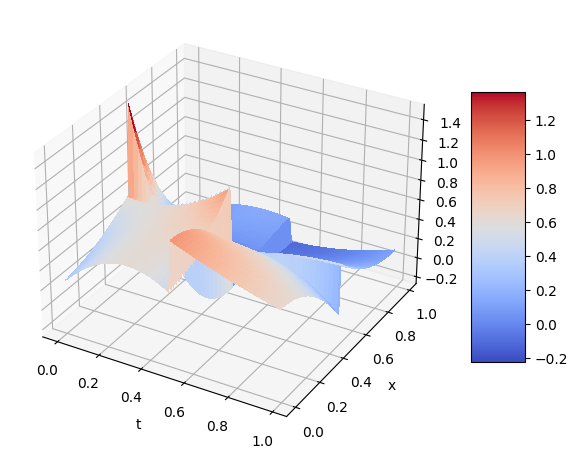

In [ ]:
sol.plot2d()

In [ ]:
sol.cell_division(0)

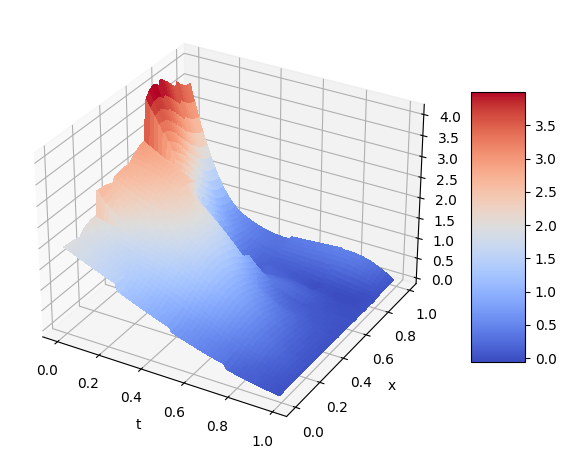

In [ ]:
sol.plot2d(func_num=1)